#Word Embeddings
https://www.tensorflow.org/tutorials/text/word_embeddings

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_datasets as tfds

In [2]:
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k', 
    split = (tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDUF7FB/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDUF7FB/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteDUF7FB/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [3]:
encoder = info.features['text'].encoder
# encoder.subwords[:20]
train_batches = train_data.shuffle(1000).padded_batch(10)
test_batches = test_data.shuffle(1000).padded_batch(10)

In [4]:
type(train_data), type(train_batches)

(tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter,
 tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter)

In [5]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[  19,  713, 1546, ...,    0,    0,    0],
       [7963, 6389,  884, ...,   14,  204, 7975],
       [ 768,  284,   14, ...,    0,    0,    0],
       ...,
       [  62,    9,    1, ...,    0,    0,    0],
       [2080, 2139,    3, ...,    0,    0,    0],
       [  19,  118, 1327, ...,    0,    0,    0]])

In [6]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(encoder.vocab_size, embedding_dim),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
hist = model.fit(
    train_batches,
    epochs=2,
    validation_data=test_batches, validation_steps=20, verbose=0)

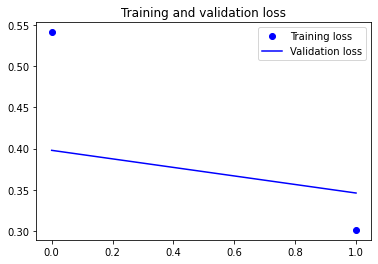

In [9]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], 'bo', label='Training loss')
plt.plot(hist.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

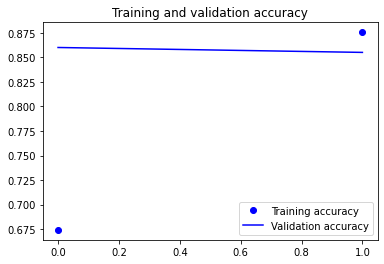

In [10]:
plt.plot(hist.history['accuracy'], 'bo', label='Training accuracy')
plt.plot(hist.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

#Retrieve the learned embeddings

In [11]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape, weights.shape[0]*weights.shape[1], weights)

(8185, 16) 130960 [[ 0.29120645  0.2727947   0.12473954 ...  0.04105081  0.00652671
   0.28056687]
 [ 0.5267185   0.41485256  0.13382386 ...  0.18866064 -0.09115577
   0.44488838]
 [ 0.5245032   0.3705597   0.14766504 ...  0.10849001  0.03003231
   0.41645363]
 ...
 [ 0.03633026 -0.04883846 -0.02527    ...  0.02106638  0.00556206
  -0.01395667]
 [-0.01266469 -0.03625218  0.03578352 ...  0.04332762 -0.03723061
   0.01823371]
 [-0.03241571 -0.00208706 -0.0005494  ...  0.02644849 -0.01275948
   0.01293638]]


##Use  Embedding Projector,

In [12]:
import io

encoder = info.features['text'].encoder

out_v = io.open('./vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('./meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
  vec = weights[num+1] # skip 0, it's padding.
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
out_v.close()
out_m.close()